# Adversarial Robustness

## Introduction & Setup

Adversarial examples are examples designed in order to cause an machine learning system to malfunction. Here, an adversary is taking a real image of a panda and adds some adversarially generated noise to get the adversarial example. The adversarial noise is designed to have small distance from the original image, so it still looks like a panda for humans. However, the model now believes its a gibbon with 99.3\% confidence. 

![picture](https://drive.google.com/uc?export=view&id=1kvJRRUDssx8ZarAH71-nxv2c2_RBNz4G)



In [ ]:
# Cloning the files from github

!git clone --branch adversarial https://github.com/oliverzhang42/safety.git
!pip3 install robustness=='1.2.1.post2'
!pip3 install torchvision=='0.10.0'

Cloning into 'safety'...
remote: Enumerating objects: 260, done.
remote: Total 260 (delta 0), reused 0 (delta 0), pack-reused 260
Receiving objects: 100% (260/260), 177.09 MiB | 14.01 MiB/s, done.
Resolving deltas: 100% (109/109), done.
Checking out files: 100% (11/11), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 95 kB 2.6 MB/s 
     |████████████████████████████████| 181 kB 24.8 MB/s 
     |████████████████████████████████| 125 kB 51.4 MB/s 
     |████████████████████████████████| 55 kB 85 kB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=4f49ae757329104f4af9c19a2592a4afc283cb082dacf63bf9dd2560878417cc
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built GPUtil
Looking in indexes: https://pypi.org/simple, https://us-pyt

In [ ]:
# Importing all the necessary libraries

import torch
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from safety.utils import utils
from safety.lesson1 import adversarial
from torch import nn
from torchvision import models

%matplotlib inline

## First Adversarial Attack using FGSM

### Untargeted FGSM

The first method we look at is the untargeted Fast Gradient Sign Method (FGSM) proposed by [Goodfellow et al.](https://arxiv.org/pdf/1412.6572.pdf). The attack constructs adversarial examples as follows:

$$x_\text{adv} = x + \epsilon\cdot\text{sign}(\nabla_xJ(\theta, x, y))$$

where 

*   $x_\text{adv}$ : Adversarial image.
*   $x$ : Original input image.
*   $y$ : Original input label.
*   $\epsilon$ : Multiplier to ensure the perturbations are small.
*   $\theta$ : Model parameters.
*   $J$ : Loss.

In a nutshell, the model tempers the input data in the direction of greatest ascent locally, which should increase the loss. The current attack formulation is considered 'untargeted' because it only seeks to maximize loss rather than to trick the model into predicting a specific label.

The FGSM attack is an example of an Lp attack, where the distortion must fall within an attack distortion budget
$||x_\text{adv} - x ||_p \leq \varepsilon $

Here, the attack obey an $l_p$ attack budget $||x_\text{FGSM} - x||_\infty = \varepsilon $

In [ ]:
def untargeted_FGSM(x_batch, true_labels, network, normalize, eps=8/255., **kwargs):
  """Generates a batch of untargeted FGSM adversarial examples

  Args:
    x_batch (torch.Tensor): the batch of unnormalized input examples.
    true_labels (torch.Tensor): the batch of true labels of the example.
    network (nn.Module): the network to attack.
    normalize (function): a function which normalizes a batch of images 
        according to standard imagenet normalization.
    eps (float): the bound on the perturbations.
  """
  network.to('cuda')
  loss_fn = nn.CrossEntropyLoss(reduction="mean")
  x_batch.requires_grad = True

  loss = loss_fn(network(x_batch), true_labels)
  loss.backward()
  grad = x_batch.grad

  x_adv = x_batch + eps * torch.sign(grad)

  return x_adv

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


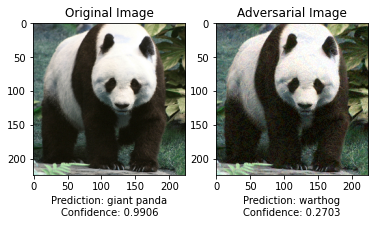

In [ ]:
# Test the method
adversarial.test_untargeted_attack(untargeted_FGSM, eps=8/255.)

If things go well, the model should switch from predicting 'giant panda' to predicting 'brown bear' or some other class. Additionally, try increasing the epsilon to see the noise more clearly.

### Targeted FGSM

In addition to the untargeted FGSM which simply seeks to maximize loss, we can also create targeted adversarial attacks, which tries to minimize the loss for a specific target. We do this using the following equation:

$$x_{adv} = x - \epsilon\cdot\text{sign}(\nabla_xJ(\theta, x, y_{target}))$$

where 

*   $x_{adv}$ : Adversarial image.
*   $x$ : Original input image.
*   $y_{target}$ : The target label.
*   $\epsilon$ : Multiplier to ensure the perturbations are small.
*   $\theta$ : Model parameters.
*   $J$ : Loss.

This attack also falls within the Lp attack budget $||x_\text{TFGSM} - x||_\infty = \varepsilon $

In [ ]:
def targeted_FGSM(x_batch, target_labels, network, normalize, eps=8/255., **kwargs):
  """Generates a batch of targeted FGSM adversarial examples

  Args:
    x_batch (torch.Tensor): the unnormalized input example.
    target_labels (torch.Tensor): the labels the model will predict after the attack.
    network (nn.Module): the network to attack.
    normalize (function): a function which normalizes a batch of images 
        according to standard imagenet normalization.
    eps (float): the bound on the perturbations.
  """
  network.to('cuda')
  loss_fn = nn.CrossEntropyLoss(reduction="mean")
  x_batch.requires_grad = True
  
  loss = loss_fn(network(x_batch), target_labels)
  loss.backward()
  grad = x_batch.grad

  x_adv = x_batch + eps * torch.sign(grad)

  return x_adv

Note that even if the implementation is perfect, FGSM is not able to generate effective targeted attacks.


The target index corresponds to a label of hen!


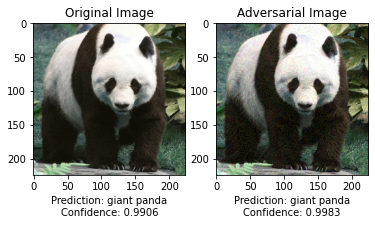

In [ ]:
adversarial.test_targeted_attack(targeted_FGSM, target_idx=8, eps=8/255.)

## Additional Adversarial Attacks



## Implementing L2 normalization and clamping

We will implement some helper functions that we can use for the Projected Gradient Descent (PGD) L2 method below.

For the normalize_l2 function we will be returning the following value

$$\frac{x}{||x||_{2}}$$

For the tensor_clamp_l2 function we will compute and return the following value

\begin{equation}
    X=
    \begin{cases}
      clamp(x), & \text{if}\ ||x-c||_2 > r \\
      x, & \text{otherwise}
    \end{cases}
  \end{equation}

where 
$ \text{clamp}(x) = c + \frac{x-c}{||x-c||_2} ⋅ r$, X is the return value, x is the input, c (center) is a tensor of the same shape as x, and r (radius) is a scalar value.

In [ ]:
def normalize_l2(x_batch, return_norm=False):
    """
    Expects x_batch.shape == [N, C, H, W]
    where N is the batch size, 
    C is the channels (or colors in our case),
    H, W are height and width respectively.

    Note: To take the l2 norm of an image, you will want to flatten its dimensions (be careful to preserve the batch dimension of x_batch).
    """
    N = x_batch.shape[0]

    l2 = torch.sqrt(torch.sum((x_batch ** 2), dim=(1,2,3)))
    assert(l2.shape == N,)

    if return_norm:
      return (x_batch / l2.view((N,1,1,1)), l2)
    else:
      return x_batch / l2.view((N,1,1,1))
    

<ipython-input-7-87a90d6ccb03>:15: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(l2.shape == x_batch.shape[0],)


In [ ]:
def tensor_clamp_l2(x_batch, center, radius):
    """Batched clamp of x into l2 ball around center of given radius."""

    ns, l2s = normalize_l2(x_batch - center, return_norm=True)
    clamped = center + ns * radius

    return torch.where(l2s > radius, clamped, x_batch)


### Projected Gradient Descent (PGD)


The FGSM attack is weak because it can only perform a single step. PGD uses multiple steps, where each step is followed by a projection step to keep the adversarial vector within the Lp attack budget. Below is the update step for the untargeted version.

$$x_\text{adv} := \text{tensor\_clamp\_l2}(x_\text{adv} + \alpha\cdot\text{sign}(\nabla_xJ(\theta, x_\text{adv}, y)))$$

In [ ]:
def PGD_l2(x_batch, true_labels, network, normalize, num_steps=20, step_size=3./255, eps=128/255., **kwargs):
        """
        :return: perturbed batch of images
        """
        # Initialize our adversial image
        x_adv = x_batch.detach().clone()
        x_adv += torch.zeros_like(x_adv).uniform_(-eps, eps)

        for _ in range(num_steps):
            x_adv.requires_grad_()
            
            # Calculate gradients
            with torch.enable_grad():
              logits = network(normalize(x_adv))
              loss = F.cross_entropy(logits, true_labels, reduction='sum')

            # Normalize the gradients with your L2
            grad = normalize_l2(torch.autograd.grad(loss, x_adv, only_inputs=True)[0])

            # Take a step in the gradient direction.
            x_adv = x_adv.detach() + step_size * grad

            # Project (by clamping) the adversarial image back onto the hypersphere around the image.
            x_adv = tensor_clamp_l2(x_adv, x_batch, eps).clamp(0, 1)

        return x_adv

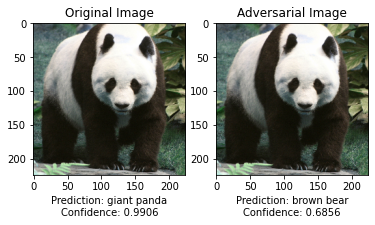

In [ ]:
adversarial.test_untargeted_attack(PGD_l2, eps=128/255.)

The above version of PGD follows the $l_2$ attack budget. We can use a slightly more relaxed $l_\infty$ budget, which should produce better results. Here, we provide both targeted and untargeted versions.

Here, we have 

$$x_\text{adv} := P(x_\text{adv} + \alpha\cdot\text{sign}(\nabla_xJ(\theta, x_\text{adv}, y)))$$

where

$$P(z) = \text{clip}(z, x - \varepsilon, x + \varepsilon) $$

`clip` is the element-wise operation that clips the value so it's within the 2nd and 3rd argument.

In [ ]:
def untargeted_PGD(x_batch, true_labels, network, normalize, num_steps=10, step_size=0.01, eps=8/255., **kwargs):
  """Generates a batch of untargeted PGD adversarial examples

  Args:
    x_batch (torch.Tensor): the batch of unnormalized input examples.
    true_labels (torch.Tensor): the batch of true labels of the example.
    network (nn.Module): the network to attack.
    normalize (function): a function which normalizes a batch of images 
        according to standard imagenet normalization.
    num_steps (int): the number of steps to run PGD.
    step_size (float): the size of each PGD step.
    eps (float): the bound on the perturbations.
  """
  x_adv = x_batch.detach().clone()
  x_adv += torch.zeros_like(x_adv).uniform_(-eps, eps)

  for i in range(num_steps):
    x_adv.requires_grad_()
    
    # Calculate gradients
    with torch.enable_grad():
      logits = network(normalize(x_adv))
      loss = F.cross_entropy(logits, true_labels, reduction='sum')
    grad = torch.autograd.grad(loss, x_adv, only_inputs=True)[0]
    
    # Perform one gradient step
    x_adv = x_adv.detach() + step_size * torch.sign(grad.detach())
    
    # `clip` operation
    x_adv = torch.maximum(x_adv, x_batch - eps)
    x_adv = torch.minimum(x_adv, x_batch + eps)

  return x_adv

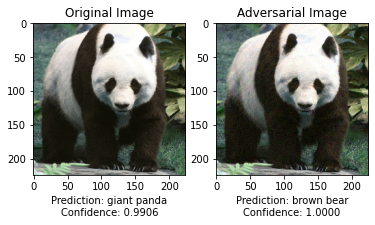

In [ ]:
adversarial.test_untargeted_attack(untargeted_PGD, eps=8/255.)

In [ ]:
def targeted_PGD(x_batch, target_labels, network, normalize, num_steps=100, step_size=0.01, eps=8/255., **kwargs):
  """Generates a batch of untargeted PGD adversarial examples

  Args:
    x_batch (torch.Tensor): the batch of preprocessed input examples.
    target_labels (torch.Tensor): the labels the model will predict after the attack.
    network (nn.Module): the network to attack.
    normalize (function): a function which normalizes a batch of images 
        according to standard imagenet normalization.
    num_steps (int): the number of steps to run PGD.
    step_size (float): the size of each PGD step.
    eps (float): the bound on the perturbations.
  """
  x_adv = x_batch.detach().clone()
  x_adv += torch.zeros_like(x_adv).uniform_(-eps, eps)

  for i in range(num_steps):
    x_adv.requires_grad_()
    
    # Calculate gradients
    with torch.enable_grad():
      logits = network(normalize(x_adv))
      loss = F.cross_entropy(logits, target_labels, reduction='sum')
    grad = torch.autograd.grad(loss, x_adv, only_inputs=True)[0]
    
    # Perform one gradient step
    # Note that this time we use gradient descent instead of gradient ascent
    x_adv = x_adv.detach() - step_size * torch.sign(grad.detach())
    
    # Project the image to the ball
    x_adv = torch.maximum(x_adv, x_batch - eps)
    x_adv = torch.minimum(x_adv, x_batch + eps)
  
  return x_adv


The target index corresponds to a label of goldfish!


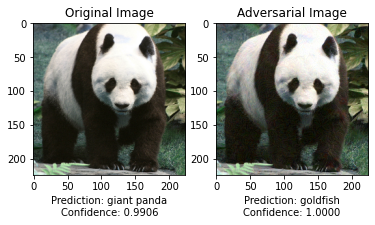

In [ ]:
# Try changing the target_idx around!
adversarial.test_targeted_attack(targeted_PGD, target_idx=1, eps=8/255.)

## Attacks on Adversarially Trained Models
We devote this section to attacking an adversarially trained model. As a reminder, a model which has been "adversarially trained" means that it has been exposed to a load of adversarial examples over training and has specifically trained to recognize them properly.

In this section, we will demonstrate that adversarial attacks look a lot different if you're attacking an adversarially trained model.

The model we use was taken from this repository and is an L∞ robust ResNet18 trained with adversarial examples of ϵ=8/255.

### Attacking Normally Trained Models


The target index corresponds to a label of brambling!


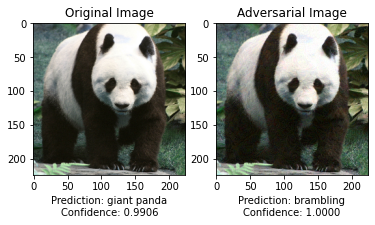

In [ ]:
# Attack a normal model (we only support targeted methods)
adversarial.attack_normal_model(
    targeted_PGD, 
    target_idx=10, 
    eps=8/255., 
    num_steps=10, 
    step_size=0.01
)

### Attacking Adversarially Trained Models

=> loading checkpoint 'safety/lesson1/checkpoints/resnet18_linf_eps8.0.ckpt'
=> loaded checkpoint 'safety/lesson1/checkpoints/resnet18_linf_eps8.0.ckpt' (epoch 90)

The target index corresponds to a label of brambling!


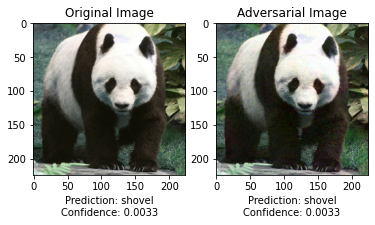

In [ ]:
# Attack an adversarially trained model (we only support targeted methods)
adversarial.attack_adversarially_trained_model(
    targeted_PGD, 
    target_idx=10, 
    eps=8/255., 
    num_steps=10, 
    step_size=0.01
)